In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_f, get_preds_and_bfs
from src.python.visualization import perf_tester

import numpy as np
import pandas as pd
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [2]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [3]:
# Cosine Decay with Restarts

initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    skip_checks=True
    )

# Train & validate

In [4]:
training_time_start = perf_counter()
losses = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

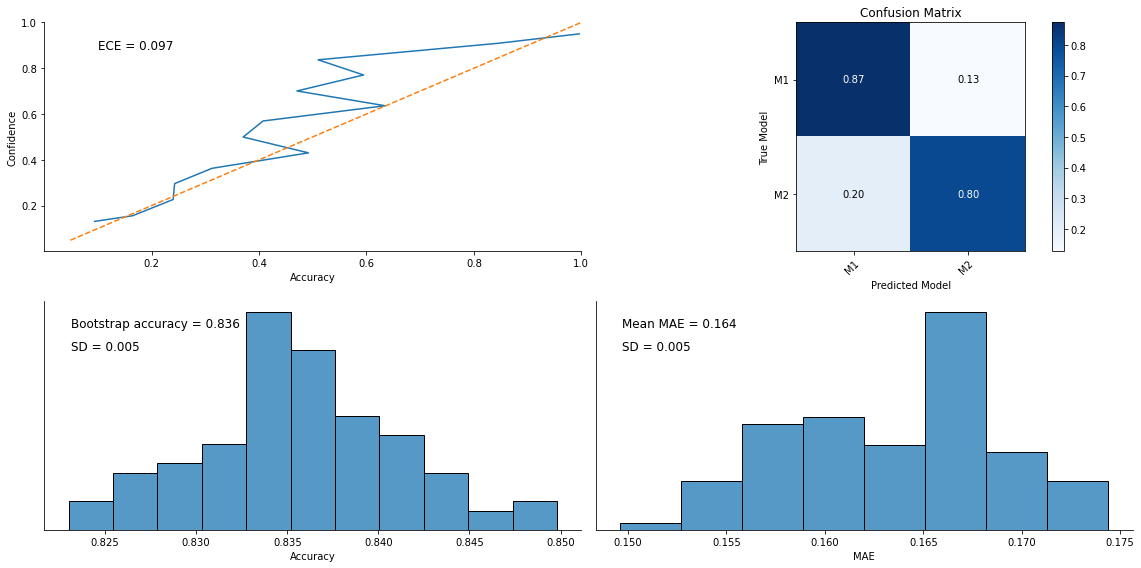

In [5]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15)

ECE = 0.097


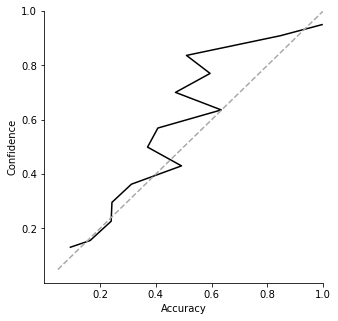

In [6]:
# Publication-ready calibration curve
perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15, pub_style=True)

# Calculate Bayes factors for bridge sampling comparison

In [5]:
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'BF_approximation_comparison')
data_filename = "test_data_bf.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [7]:
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data, training_time_start, training_time_stop, losses)
#comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.579586,0.420414,0,0.725369,1.734369,0.146455,0.604693
1,2,1,0.312148,0.687852,1,2.203606,1.734369,0.146455,0.604693
2,3,1,0.292862,0.707138,1,2.414577,1.734369,0.146455,0.604693
3,4,1,0.400188,0.599812,1,1.498823,1.734369,0.146455,0.604693
4,5,0,0.564618,0.435382,0,0.771110,1.734369,0.146455,0.604693


In [ ]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)